### set session

In [20]:
name = 'ANB1'
session = '20231030_d5'
num_trials = 183
day = 5

### imports

In [21]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_settings
from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.select_trials import select_hit_trials
from common.make_percent_scaled import make_percent_scaled
from common.extract_movement_intervals import extract_movement_intervals
from jerk.get_jerks import get_jerks

In [22]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

Velocity_folder = "../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"
PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

respMTX shape: (183, 7)
MTXTrialType shape: (1000, 5)
number of trials: 183


for mac:

In [23]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANB1/Jerk_ANB1_20231030_d5/: File exists


for windows:

In [24]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANB1/Jerk_ANB1_20231030_d5/: File exists


### An example window cutoff frequency calculation

In [25]:
samples = 201
f_sampling = 5888
M = (samples - 1) / 2
f_c=5 / (3.2*M - 4.6)
f_cutoff = f_c /2 *f_sampling
print('f_cutoff', f_cutoff, "Hz =", 1/(f_cutoff) *1000, 'ms')
print('200 Hz = 5 ms')
print('fastest movement: about', 1/50 * 1000, 'ms')

f_cutoff 46.6708941027267 Hz = 21.42663043478261 ms
200 Hz = 5 ms
fastest movement: about 20.0 ms


### calculate jerks for all trials

In [26]:
window_duration = 0.1
get_jerks(num_trials, window_duration, Velocity_folder, PreprocessLeverData_folder, output_folder)

samples per window:  494
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588
samples per window:  588


### Extract just the leverpress movement jerks

In [27]:
hit_movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
jerks = extract_movement_intervals(hit_movement_informations, 'jerk', output_folder, PreprocessLeverData_folder, output_folder)

plot

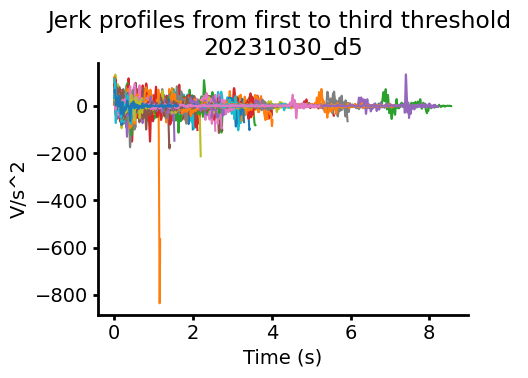

In [28]:
set_matplotlib_settings()

for jerk in jerks:
    plt.plot(jerk[0,:],jerk[1,:])
plt.xlabel("Time (s)")
plt.ylabel("V/s^2")
plt.title("Jerk profiles from first to third threshold \n"+session)
plt.show()

### Make completion scaled jerks

In [29]:
hit_trials = select_hit_trials(respMTX, num_trials)
num_interpolation_samples = 10*10000
jerks_percent_scaled = make_percent_scaled(hit_trials, num_interpolation_samples, 'jerkmovement', output_folder, output_folder)

101  hit trials in this session.
percent scaled shape:  (101, 100000)


plot

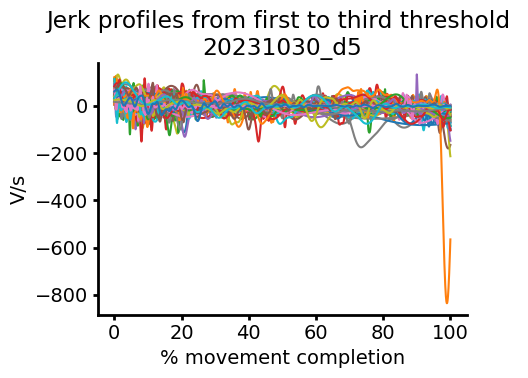

In [30]:
x_range = np.array(range(0,num_interpolation_samples)) * 100 / num_interpolation_samples
for jerk_percent_scaled in jerks_percent_scaled:
    plt.plot(x_range, jerk_percent_scaled)
plt.xlabel("% movement completion")
plt.ylabel("V/s")
plt.title("Jerk profiles from first to third threshold \n"+session)
plt.show()

### Find the peak of the movement

Find the index of the maximum value of leverdata in movement_trial#.npy

### Calculate the minimum jerk from start of movement to peak

1) $x(0)=x_0$
2) $v(0)=v_0$
3) $a(0)=a_0$ and 
4) $x(t_f)=x_f$
5) $v(t_f)=v_f$
6) $a(t_f)=a_f$

- First point is the left_index, second point is the peak
- Record the leverdata value
- record the velocity value
- acceleration = velocity derivative of a Taylor polynomial of degree 4 with a window of window_duration at each of the points
- solve boundary conditions


### Calculate the minimum jerk from peak to end of movement